# Redes Neuronales Recurrentes (RNN)

In [1]:
import keras

Using TensorFlow backend.


Keras proporciona una capa recurrente muy simple, sin ningún tipo de aditivos ni mejoras: la capa SimpleRNN.

In [2]:
from keras.layers import SimpleRNN

Como el resto de capas de Keras, SimpleRNN procesa batches de secuencias, lo que quiere decir que toma como entrada algo de la forma ***(batch_size, timesteps, input_features)***.

Esta capa tiene dos modos de ejcución. Para cada secuencia de entrada puede:
- Devolver la última salida del procesamiento de la secuencia de entrada (un tensor de tamaño ***(batch_size, output_features)***), o
- Devolver la secuencia completa de salidas (un tensor de tamaño ***(batch_size, timesteps, output_features)***).

La elección de estos dos modos se hace por medio del argumento return_sequences:

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Estas capas se pueden apilar como cualquier otra de Keras (teniendo en cuenta que, para que colapsen, ha de usarse el modo de devolución de secuencias completas):

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Probemos cómo se comporta esta capa en el ejemplo de clasificación de opiniones de IMDB. Primero, debemos comenzar preprocesando los datos:

In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Ahora entrenamos una red en la que hemos añadido una capa Embedding y otra SimpleRNN:

In [6]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Z:\Programacion\Anaconda\envs\deepl\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.5723 - acc: 0.6953 - val_loss: 0.4099 - val_acc: 0.8282
Epoch 2/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.3473 - acc: 0.8610 - val_loss: 0.3621 - val_acc: 0.8468
Epoch 3/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.2732 - acc: 0.8935 - val_loss: 0.4181 - val_acc: 0.8302
Epoch 4/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.2260 - acc: 0.9162 - val_loss: 0.3640 - val_acc: 0.8690
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1859 - acc: 0.9323 - val_loss: 0.3929 - val_acc: 0.8618
Epoch 6/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1419 - acc: 0.9500 - val_loss: 0.4167 - val_acc: 0.8416
Epoch 7/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.1123 - acc: 0.9616 - val_loss: 0.7436 - val_acc:

Y mostramos cómo se ha comportado el entrenamiento:

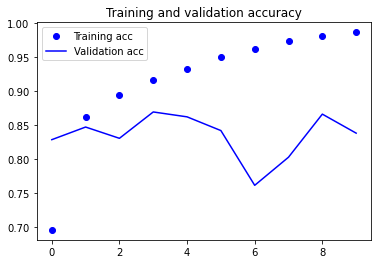

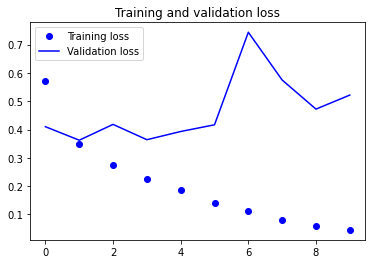

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Vemos que muy pronto se produce un sobreajuste y nos quedamos por debajo del 88% conseguido por el método directo de las capas densas visto en un ejemplo anterior. Parte del problema, por supuesto, es que ahora las entradas solo consideran las primeras 500 palabras, y no la secuencia completa, pero además la capa SimpleRNN no es suficientemente buena para procesar secuencias largas, ya que sufre el problema del **desvanecimiento del gradiente** habitual en capas profundas, lo que significa que apenas puede recordar estados que estén muy atrás en el tiempo.

A continuación veremos otros modelos recurrentes que intentan evitar este problema.

## Un ejemplo de LSTM en Keras

Vamos a abordar el mismo problema de antes pero sustituyendo la capa SimpleRNN por una capa LSTM. Aunque esta nueva capa tiene muchos argumentos, dejaremos por defecto los que trae Keras (que no funcionan mal) y solo ajustaremos la dimensión de salida :

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Z:\Programacion\Anaconda\envs\deepl\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.5088 - acc: 0.7638 - val_loss: 0.8101 - val_acc: 0.6642
Epoch 2/10
 1408/20000 [=>............................] - ETA: 43s - loss: 0.3291 - acc: 0.8743

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Alcanzamos un 88% de accuracy, que supera el de la red con SimpleRNN ya que LSTM sufre menos el efecto del desvanecimiento, y aproximadamente igual (quizás un poco mejor) que el de la red densa (que había recibido más información sobre cada opinión).

Sin embargo, esta solución con LSTM requiere mucha más potencia computacional que la densa, y los resultados no son tan llamativos. Por supuesto, una razón puede ser que no hemos hecho ningún ajuste fino de los parámetros de la red (por ejemplo, la dimensión de inmersión), por lo que quizás no estamos obteniendo el rendimiento que podíamos. Pero quizás la razón principal es que analizar la estructura completa de las opiniones quizás no sea tan importante para evaluar un problema de análisis de sentimientos, y quizás solo sea suficiente con saber qué palabras, y con qué frecuencia, aparecen en la opinión.

Pero hay problemas mucho más duros que este para los que las redes densas no proporcionarían una solución suficientemente buena, y para los que las LSTM sí funcionan bien, como, por ejemplo, la traducción automática.